In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense
from tensorflow.keras.callbacks import History
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [ ]:
audio_dir = 'Persian-Speech-To-Text-Audios'
spectrogram_dir = '/Users/homabarghamadi/Downloads/DL-HW4-Dataset/spectrograms'
audio_files = os.listdir(audio_dir)

for file in audio_files:
    y, sr = librosa.load(os.path.join(audio_dir, file))
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    np.save(os.path.join(spectrogram_dir, file.replace('.wav', '.npy')), spectrogram)

In [ ]:
from sklearn.preprocessing import LabelEncoder
df = pd.read_excel('Persian-Speech-To-Text-Maps.xlsx')
char_encoder = LabelEncoder()
chars = sorted(list(set(df['text'].str.cat(sep=''))))
char_encoder.fit(chars)
num_chars = len(char_encoder.classes_)
print('Number of unique characters:', num_chars)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
num_words = len(tokenizer.word_index) + 1
print('Number of unique words:', num_words)
if num_chars < num_words:
    print("Character-level encoding is better as it has fewer unique tokens.")
else:
    print("Word-level encoding is better as it has fewer unique tokens.")


In [ ]:
df = pd.read_excel('Persian-Speech-To-Text-Maps.xlsx')
df['audio'] = df['audio'].apply(lambda path: os.path.basename(path))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
sequences = pad_sequences(sequences)
spectrograms = []
max_length = 0
for file in df['audio']:
    spectrogram_path = os.path.join(spectrogram_dir, file.replace('.wav', '.npy'))

    if os.path.exists(spectrogram_path):
        spectrogram = np.load(spectrogram_path)
        spectrograms.append(spectrogram)

        if spectrogram.shape[1] > max_length:
            max_length = spectrogram.shape[1]
    else:
        print(f"Spectrogram file not found for {file}")
spectrograms_padded = []
for spectrogram in spectrograms:
    padded = np.pad(spectrogram, ((0, 0), (0, max_length - spectrogram.shape[1])))
    spectrograms_padded.append(padded)
spectrograms = np.array(spectrograms_padded)
X_train, X_test, y_train, y_test = train_test_split(spectrograms, sequences, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
X_train.shape

In [ ]:
from keras.layers import GlobalAveragePooling1D, RepeatVector, TimeDistributed, LSTM, Dropout
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import BatchNormalization

model_RNN = Sequential()
model_RNN.add(SimpleRNN(256, input_shape=(128, 431), return_sequences=True))
model_RNN.add(Dropout(0.2))
model_RNN.add(GlobalAveragePooling1D())
model_RNN.add(BatchNormalization())
model_RNN.add(RepeatVector(30))
model_RNN.add(BatchNormalization())
model_RNN.add(TimeDistributed(Dense(2102, activation='sigmoid')))
model_RNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.layers import GlobalAveragePooling1D, RepeatVector, TimeDistributed, LSTM, Dropout
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Dense

model_lstm = Sequential()
model_lstm.add(LSTM(256, input_shape=(128, 431), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(GlobalAveragePooling1D())
model_lstm.add(BatchNormalization())
model_lstm.add(RepeatVector(30))
model_lstm.add(BatchNormalization())
model_lstm.add(TimeDistributed(Dense(2102, activation='sigmoid')))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.layers import GlobalAveragePooling1D, RepeatVector, TimeDistributed, LSTM, Dropout
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Dense

model_GRU = Sequential()
model_GRU.add(GRU(256, input_shape=(128, 431), return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GlobalAveragePooling1D())
model_GRU.add(BatchNormalization())
model_GRU.add(RepeatVector(30))
model_GRU.add(BatchNormalization())
model_GRU.add(TimeDistributed(Dense(2102, activation='sigmoid')))
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print("train RNN model")
history_RNN = model_RNN.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))
print("train LSTM model")
history_lstm = model_lstm.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))
print("train GRU model")
history_GRU = model_GRU.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

In [ ]:
loss_RNN, acc_RNN = model_RNN.evaluate(X_test, y_test)
loss_lstm, acc_lstm = model_lstm.evaluate(X_test, y_test)
loss_GRU, acc_GRU = model_GRU.evaluate(X_test, y_test)

In [ ]:
y_pred_RNN = model_RNN.predict(X_test)
y_pred_lstm = model_lstm.predict(X_test)
y_pred_GRU = model_GRU.predict(X_test)

In [ ]:
y_pred_RNN = np.argmax(y_pred_RNN, axis=2)
y_pred_lstm = np.argmax(y_pred_lstm, axis=2)
y_pred_GRU = np.argmax(y_pred_GRU, axis=2)

In [ ]:
f1_score_RNN = f1_score(y_test.flatten(), y_pred_RNN.flatten(), average='weighted')
f1_score_lstm = f1_score(y_test.flatten(), y_pred_lstm.flatten(), average='weighted')
f1_score_GRU = f1_score(y_test.flatten(), y_pred_GRU.flatten(), average='weighted')

In [ ]:
print("RNN Model:")
print("Loss:", loss_RNN)
print("Accuracy:", acc_RNN)
print("F1 Score:", f1_score_RNN)

print("\nLSTM Model:")
print("Loss:", loss_lstm)
print("Accuracy:", acc_lstm)
print("F1 Score:", f1_score_lstm)

print("\nGRU Model:")
print("Loss:", loss_GRU)
print("Accuracy:", acc_GRU)
print("F1 Score:", f1_score_GRU)

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_RNN.history['accuracy']) + 1)

plt.plot(epochs, history_RNN.history['accuracy'], 'b', label='RNN Training Accuracy')
plt.plot(epochs, history_RNN.history['val_accuracy'], 'g', label='RNN Validation Accuracy')
plt.plot(epochs, history_lstm.history['accuracy'], 'r', label='LSTM Training Accuracy')
plt.plot(epochs, history_lstm.history['val_accuracy'], 'm', label='LSTM Validation Accuracy')
plt.plot(epochs, history_GRU.history['accuracy'], 'c', label='GRU Training Accuracy')
plt.plot(epochs, history_GRU.history['val_accuracy'], 'y', label='GRU Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predicted_sequences_RNN = model_RNN.predict(X_test)
predicted_sequences_RNN = np.argmax(predicted_sequences_RNN, axis=2)
predicted_texts_RNN = tokenizer.sequences_to_texts(predicted_sequences_RNN)
original_texts = tokenizer.sequences_to_texts(y_test)
for i in range(len(predicted_texts_RNN)):
    print("Audio File:", audio_files[i])
    print("Predicted Text:", predicted_texts_RNN[i])
    print("Original Text:", original_texts[i])
    print()


In [11]:
from keras.layers import GlobalAveragePooling1D, RepeatVector, TimeDistributed, LSTM, Dropout
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Dense

model_GRU = Sequential()
model_GRU.add(GRU(256, input_shape=(128, 431), return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GlobalAveragePooling1D())
model_GRU.add(BatchNormalization())
model_GRU.add(RepeatVector(30))
model_GRU.add(BatchNormalization())
model_GRU.add(TimeDistributed(Dense(2102, activation='sigmoid')))
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-06-19 21:32:07.434717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:32:07.435563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:32:07.436637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
print("train RNN model")
history_RNN = model_RNN.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))
print("train LSTM model")
history_lstm = model_lstm.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))
print("train GRU model")
history_GRU = model_GRU.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

train RNN model
Epoch 1/20
11/11 [==============================] - 1s 127ms/step - loss: 5.7877 - accuracy: 0.2206 - val_loss: 6.2836 - val_accuracy: 0.2124
Epoch 2/20
11/11 [==============================] - 1s 134ms/step - loss: 5.7580 - accuracy: 0.2144 - val_loss: 6.1986 - val_accuracy: 0.2311
Epoch 3/20
11/11 [==============================] - 2s 145ms/step - loss: 5.6635 - accuracy: 0.2160 - val_loss: 6.2008 - val_accuracy: 0.2333
Epoch 4/20
11/11 [==============================] - 1s 104ms/step - loss: 5.6115 - accuracy: 0.2244 - val_loss: 6.2735 - val_accuracy: 0.2169
Epoch 5/20
11/11 [==============================] - 1s 101ms/step - loss: 5.4501 - accuracy: 0.2377 - val_loss: 6.0934 - val_accuracy: 0.2431
Epoch 6/20
11/11 [==============================] - 1s 107ms/step - loss: 5.3745 - accuracy: 0.2374 - val_loss: 6.0997 - val_accuracy: 0.2422
Epoch 7/20
11/11 [==============================] - 1s 103ms/step - loss: 5.3872 - accuracy: 0.2464 - val_loss: 5.9778 - val_accurac

2023-06-19 21:35:42.995405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:35:42.998195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:35:42.999821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 7.6623 - accuracy: 0.0172

2023-06-19 21:35:47.771338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:35:47.772234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:35:47.773329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 6s 248ms/step - loss: 7.6623 - accuracy: 0.0172 - val_loss: 7.6297 - val_accuracy: 0.0218
Epoch 2/20
11/11 [==============================] - 3s 263ms/step - loss: 7.5010 - accuracy: 0.0072 - val_loss: 7.5918 - val_accuracy: 0.1209
Epoch 3/20
11/11 [==============================] - 2s 203ms/step - loss: 7.3995 - accuracy: 0.0110 - val_loss: 7.5526 - val_accuracy: 0.1173
Epoch 4/20
11/11 [==============================] - 2s 193ms/step - loss: 7.3085 - accuracy: 0.0170 - val_loss: 7.5002 - val_accuracy: 0.1231
Epoch 5/20
11/11 [==============================] - 2s 208ms/step - loss: 7.1933 - accuracy: 0.0164 - val_loss: 7.3700 - val_accuracy: 0.1182
Epoch 6/20
11/11 [==============================] - 2s 217ms/step - loss: 6.9956 - accuracy: 0.0178 - val_loss: 7.1860 - val_accuracy: 0.1391
Epoch 7/20
11/11 [==============================] - 2s 190ms/step - loss: 6.6551 - accuracy: 0.0157 - val_loss: 7.1032 - val_accuracy: 0.3627
Epoch 8/20
11/11 

In [15]:
loss_RNN, acc_RNN = model_RNN.evaluate(X_test, y_test)
loss_lstm, acc_lstm = model_lstm.evaluate(X_test, y_test)
loss_GRU, acc_GRU = model_GRU.evaluate(X_test, y_test)

3/3 [==============================] - 0s 85ms/step - loss: 6.7477 - accuracy: 0.1462


In [16]:
y_pred_RNN = model_RNN.predict(X_test)
y_pred_lstm = model_lstm.predict(X_test)
y_pred_GRU = model_GRU.predict(X_test)

3/3 [==============================] - 0s 37ms/step


2023-06-19 21:41:06.927284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:41:06.928857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:41:06.929851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 85ms/step


2023-06-19 21:41:07.561279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 21:41:07.562241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 21:41:07.563227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 74ms/step


In [17]:
y_pred_RNN = np.argmax(y_pred_RNN, axis=2)
y_pred_lstm = np.argmax(y_pred_lstm, axis=2)
y_pred_GRU = np.argmax(y_pred_GRU, axis=2)

In [18]:
f1_score_RNN = f1_score(y_test.flatten(), y_pred_RNN.flatten(), average='weighted')
f1_score_lstm = f1_score(y_test.flatten(), y_pred_lstm.flatten(), average='weighted')
f1_score_GRU = f1_score(y_test.flatten(), y_pred_GRU.flatten(), average='weighted')

In [19]:
print("RNN Model:")
print("Loss:", loss_RNN)
print("Accuracy:", acc_RNN)
print("F1 Score:", f1_score_RNN)

print("\nLSTM Model:")
print("Loss:", loss_lstm)
print("Accuracy:", acc_lstm)
print("F1 Score:", f1_score_lstm)

print("\nGRU Model:")
print("Loss:", loss_GRU)
print("Accuracy:", acc_GRU)
print("F1 Score:", f1_score_GRU)

RNN Model:
Loss: 6.350351333618164
Accuracy: 0.24266666173934937
F1 Score: 0.19606181015452537

LSTM Model:
Loss: 6.47873592376709
Accuracy: 0.19200000166893005
F1 Score: 0.187392

GRU Model:
Loss: 6.7476806640625
Accuracy: 0.14622221887111664
F1 Score: 0.1574170710819298


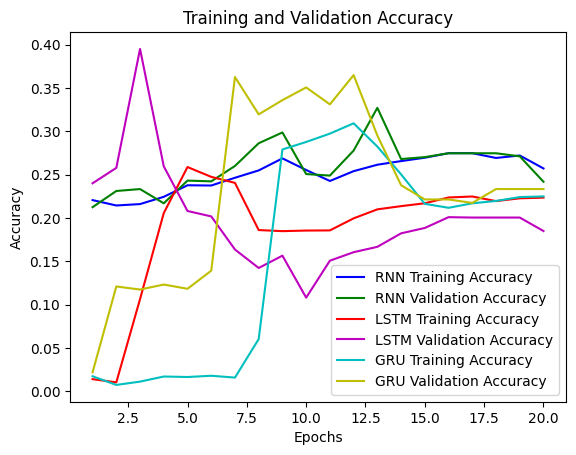

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_RNN.history['accuracy']) + 1)

plt.plot(epochs, history_RNN.history['accuracy'], 'b', label='RNN Training Accuracy')
plt.plot(epochs, history_RNN.history['val_accuracy'], 'g', label='RNN Validation Accuracy')
plt.plot(epochs, history_lstm.history['accuracy'], 'r', label='LSTM Training Accuracy')
plt.plot(epochs, history_lstm.history['val_accuracy'], 'm', label='LSTM Validation Accuracy')
plt.plot(epochs, history_GRU.history['accuracy'], 'c', label='GRU Training Accuracy')
plt.plot(epochs, history_GRU.history['val_accuracy'], 'y', label='GRU Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
predicted_sequences_RNN = model_RNN.predict(X_test)
predicted_sequences_RNN = np.argmax(predicted_sequences_RNN, axis=2)
predicted_texts_RNN = tokenizer.sequences_to_texts(predicted_sequences_RNN)
original_texts = tokenizer.sequences_to_texts(y_test)
for i in range(len(predicted_texts_RNN)):
    print("Audio File:", audio_files[i])
    print("Predicted Text:", predicted_texts_RNN[i])
    print("Original Text:", original_texts[i])
    print()


3/3 [==============================] - 0s 35ms/step
Audio File: 12441949.wav
Predicted Text: 
Original Text: دیواره ی شمالی که ارتفاعات محدودی از این دیواره در استان تهران و بقیه ی آن در استان مازندران قرار دارد

Audio File: 12441975.wav
Predicted Text: 
Original Text: و تا دریاچه ی نمک در کویر مرکزی ایران امتداد دارد و در نهایت به دریاچه ی حوض سلطان میریزد

Audio File: 12560011.wav
Predicted Text: 
Original Text: دلاور همچنان چند دقیقه ای در دل سکوت سر خورد جلو رفت یکی از جاشو ها

Audio File: 12560213.wav
Predicted Text: 
Original Text: دهستان پس قلعه در انتهای منطقه ی ییلاقی سربند و دربند و دو کیلومتری شمیران قرار دارد پس قلعه

Audio File: 12560207.wav
Predicted Text: ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت ژاکت
Original Text: اما اینبار دلاور بر موجی باورنکردنی شناور شد موجی که هیچ کس تا آن وقت

Audio File: 12440128.wav
Predicted Text: پوسته پوسته پوسته پوسته پوسته پوسته پوسته پو